In [1]:
import os
import pandas as pd

QUALITY_PATH = os.path.join("..\datasets", "quality")
cvs_path = os.path.join(QUALITY_PATH, "quality.csv")
quality = pd.read_csv(cvs_path)

In [2]:
quality.head()

,DevEffort,TestEffort,SIT,UAT,PRD,Quality
0,6605.0,3267.0,96,0,1,0
1,6509.5,1074.5,51,5,3,1
2,41987.0,5508.5,123,5,5,1
3,48957.0,5331.0,192,4,10,1
4,1343.0,177.0,17,0,3,1


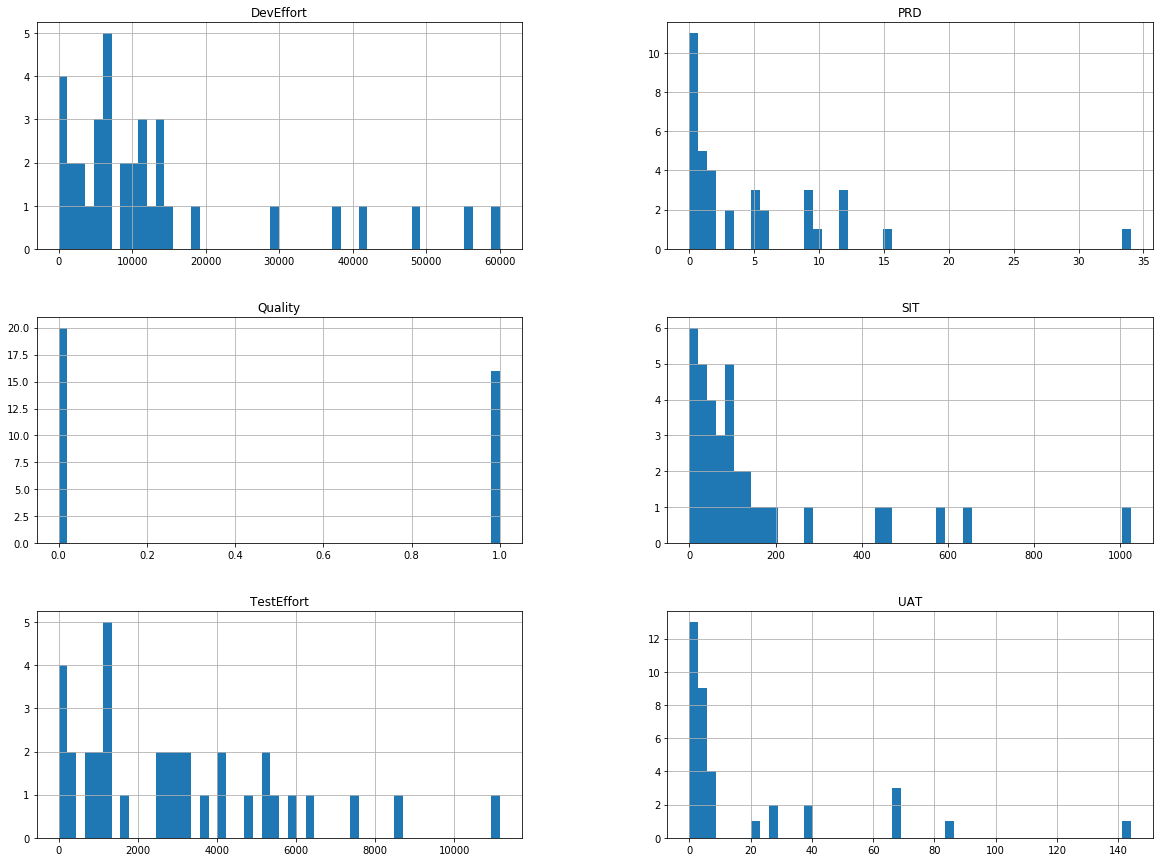

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
quality.hist(bins=50, figsize=(20,15))
plt.show()

In [3]:
# 相关系数
corr_matrix = quality.corr()
corr_matrix["PRD"].sort_values(ascending=False)

PRD           1.000000
TestEffort    0.810560
DevEffort     0.759016
SIT           0.709651
Quality       0.682635
UAT           0.627808
Name: PRD, dtype: float64

In [4]:
import numpy as np
# quality["quality_cat"] = quality["Quality"] * 100
# quality["quality_cat"].where(quality["quality_cat"] > 1, 1.00, inplace = True)
# quality["quality_cat"].where(quality["quality_cat"] <= 1.00, 2.00, inplace = True)

#quality["Quality"].value_counts()

In [5]:
# 训练集和测试集数据
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(quality, quality["Quality"]):
    strat_train_set = quality.loc[train_index]
    strat_test_set = quality.loc[test_index]

In [6]:
quality = strat_train_set.drop(["PRD", "Quality"], axis = 1)
quality_labels = strat_train_set["PRD"].copy()

In [7]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [8]:
# 自定义Selector
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [9]:
# 预处理数据
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_attribs = list(quality)
cat_attribs = ["Quality"]
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

full_pipeline = FeatureUnion(transformer_list = [
    ("num_pipeline", num_pipeline),
#     ("cat_pipeline", cat_pipeline),
])
quality_prepared = full_pipeline.fit_transform(quality)
print(quality_prepared.shape)

(28, 4)


In [10]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [11]:
# 训练线性回归模型
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(quality_prepared, quality_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
# 线性回归交叉验证
from sklearn.model_selection import cross_val_score
line_scores = cross_val_score(lin_reg, quality_prepared, quality_labels, scoring="neg_mean_squared_error", cv = 10)
line_rmse_scores = np.sqrt(-line_scores)
display_scores(line_rmse_scores)

Scores: [ 2.24795253  3.77182416  3.11105456  9.9693268   0.73375521  3.04199871
  3.46530593  2.94569511  7.24181328  1.518485  ]
Mean: 3.804721127
Standard deviation: 2.62324857185


In [13]:
# 训练决策树回归模型
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state = 42)
tree_reg.fit(quality_prepared, quality_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [14]:
# 决策树交叉验证
tree_scores = cross_val_score(tree_reg, quality_prepared, quality_labels, scoring="neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [ 1.41421356  7.32575366  2.94392029  2.          6.27162924  3.51188458
  2.51661148  1.82574186  1.          2.12132034]
Mean: 3.09310750151
Standard deviation: 1.98729782639


In [15]:
# 随机森林模型
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(quality_prepared, quality_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [16]:
# 随机森林交叉验证
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, quality_prepared, quality_labels,
                                scoring="neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 0.78315601  5.03487835  3.72469238  1.06770783  3.92173431  1.77106371
  3.26343377  1.4571662   1.0511898   1.85067555]
Mean: 2.39256979138
Standard deviation: 1.39831200383


In [17]:
# Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators' : [3, 10, 30], 'max_features' : [2, 4]},
    {'bootstrap': [False], 'n_estimators' : [3, 10], 'max_features' : [2, 3, 4]}
]
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring='neg_mean_squared_error')
grid_search.fit(quality_prepared, quality_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [18]:
print(grid_search.best_params_)

{'bootstrap': False, 'max_features': 2, 'n_estimators': 10}


In [19]:
print(grid_search.best_estimator_);

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)


In [21]:
from sklearn.metrics import mean_squared_error

final_model = grid_search.best_estimator_
X_test = strat_test_set.drop(["PRD", "Quality"], axis = 1)
y_test = strat_test_set["PRD"].copy()
X_test_prepared = full_pipeline.transform(X_test)

final_scores = cross_val_score(final_model, quality_prepared, quality_labels,
                                scoring="neg_mean_squared_error", cv=10)
final_rmse_scores = np.sqrt(-final_scores)
display_scores(final_rmse_scores)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
# print(final_rmse)
print(X_test)
print(y_test)
print(final_predictions)


Scores: [ 1.02469508  4.41210456  3.56697818  1.14309521  2.59743463  1.70684895
  2.64889914  1.36747943  0.92195445  1.8       ]
Mean: 2.11894896332
Standard deviation: 1.10832694823
    DevEffort  TestEffort  SIT  UAT
1      6509.5      1074.5   51    5
2     41987.0      5508.5  123    5
21     6403.0      4217.0   61    4
12    13622.5      4168.0   83    7
17    11545.0      3336.0   76    0
9     59987.0     11143.0  646   69
29        0.0      1177.5    0    0
23    11902.0      2460.5  174   26
1      3
2      5
21     0
12     2
17     0
9     34
29     0
23     6
Name: PRD, dtype: int64
[  0.9   9.9   1.5   0.9   0.3  13.5   0.7   5.5]
